In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [36]:
require 'paths'
require 'image'

relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

labels:apply(function(x) return x == 0 and 2 or x end)

collectgarbage()

### Render labels for displaying

In [37]:
function renderLabels(labels, img)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
            if not LUT[labels[i][j]] then
                print(labels[i][j], i, j)
            end
            for k, color in ipairs(LUT[labels[i][j]]) do
                retval[k][i][j] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = 0.65
        retval:mul(labelsBlendCoeff)
        retval:add(img * (1 - labelsBlendCoeff))
    end
    
    return retval
end

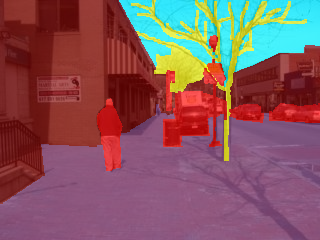

In [55]:
-- example blending
local k = 17
itorch.image(renderLabels(labels[k], images[k]))

In [56]:
require 'Integral-c-multi'

true	


In [57]:
mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

In [105]:
net = nn.Sequential()
net:add(Integral(24, 240, 320))
net:add(nn.SpatialConvolutionMM(3*24, 16, 1, 1, 1, 1))
net:add(nn.LeakyReLU(0.01))
net:add(Integral(12, 240, 320))
net:add(nn.SpatialConvolutionMM(16*12, 8, 1, 1, 1, 1))
net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

params, gradParams = net:getParameters()

local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels))

In [106]:
require 'optim'

datasetIdx = 1

optimState = {
    learningRate = 2.5e-2,
    learningRateDecay = 0.9978
}

In [107]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

In [108]:
losses = {}

In [110]:
avgLoss = 0

for iter = 1,10 do
    windowDebugger_1:add(net:get(1))
    windowDebugger_2:add(net:get(4))

    function feval(params)
        gradParams:zero()

        local input = image.rgb2yuv(images[datasetIdx])
        local target = labels[datasetIdx]:view(240*320)
        
        local outputs = net:forward(input)
        local loss = criterion:forward(outputs, target)

        local dLoss_dOutputs = criterion:backward(outputs, target)
        net:updateGradInput(input, dLoss_dOutputs)
        net:accGradParameters(input, dLoss_dOutputs)

        datasetIdx = datasetIdx % labels:size(1) + 1
        
        return loss, gradParams
    end

    local _, loss = optim.adam(feval, params, optimState)
    avgLoss = avgLoss + loss[1]
    
    collectgarbage()
    
    datasetIdx = datasetIdx % labels:size(1) + 1

    local outputFreq = 4
    if iter % outputFreq == 0 then
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
    end
    
    local saveFreq = 50
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save('SB segmentation/net.t7', net)
        torch.save('SB segmentation/loss-history.t7', losses)
        windowDebugger_1:exportVideo('SB segmentation/int-layer-1.avi')
        windowDebugger_2:exportVideo('SB segmentation/int-layer-2.avi')
    end
end

2.1434078216553	


2.1455526351929	


2.1404459476471	


2.7446653842926	


1.6601082086563	


1.5635623931885	


1.6107249259949	


1.6600195169449	


1.7475984096527	


4.8479294776917	


In [116]:
require 'gnuplot'
gnuplot.plot(torch.Tensor(torch.load('SB segmentation/loss-history.t7')), '-')